In [1]:
# Library Import
# datasets 와 동일한 계층 폴더에서 실행하면 됨
import os
import json
import shutil
from tqdm import tqdm

In [6]:
def convert_coco_to_yolo_format(root_dir: str, json_file: str, save_dir: str):
# Check directory
    try:
        assert os.path.exists(os.path.join(root_dir, save_dir, "images")) == True
        assert os.path.exists(os.path.join(root_dir, save_dir, "labels")) == True
    except:
        os.makedirs(os.path.join(root_dir, save_dir, "images"), exist_ok=True)
        os.makedirs(os.path.join(root_dir, save_dir, "labels"), exist_ok=True)
    finally:
        print("Finish make directory")

# Load json
    with open(os.path.join(root_dir, json_file), 'r') as f:
        coco_json = json.load(f)
    anoots = coco_json["annotations"]

    print("Start converting...")
    for image in tqdm(sorted(coco_json["images"], key=lambda x: x["id"])):
        w, h, file_name, image_id = image["width"], image["height"], image["file_name"], image["id"]
        file_name = file_name.split("/")[1]
    # filtering annotations
        obj_candits = list(filter(lambda x: x["image_id"] == image_id, anoots))
    # Save txt format to train yolo
        with open(os.path.join(root_dir, save_dir, "labels", f"{file_name[:-4]}.txt"), "w") as f:
            for obj_candit in obj_candits:
             # x1 y1 w h -> cx cy w h               
                cat_id = obj_candit["category_id"]

                x1, y1, width, height = obj_candit["bbox"]
                scaled_cx, scaled_cy = (x1+width/2) / w, (y1+height/2) / h
                scaled_width, scaled_height = width / w, height / h
                f.write("%s %.3f %.3f %.3f %.3f\n" %(cat_id, scaled_cx, scaled_cy, scaled_width, scaled_height))
            f.close()    # Copy image to new directory
        shutil.copy(os.path.join(root_dir, "train", file_name), os.path.join(root_dir, save_dir, "images", file_name))
    print("Finish converting...")

In [10]:
convert_coco_to_yolo_format("../../dataset", "train.json", "yolo_train")

Finish make directory
Start converting...


 36%|███▋      | 1775/4883 [00:04<00:08, 360.23it/s]

In [10]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
model.train(data="./ultralytics/ultralytics/cfg/default-custom.yaml", epochs=100, imgsz=640, project="yolo_train", name="yolov8n", device=0) #1024

New https://pypi.org/project/ultralytics/8.0.239 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.236 🚀 Python-3.10.13 torch-1.12.1+cu116 CUDA:0 (Tesla V100-SXM2-32GB, 32510MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./ultralytics/ultralytics/cfg/default-custom.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=yolo_train, name=yolov8n15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /data/ephemeral/home/level2-objectdetection-cv-10/dataset/yolo_train/labels... 3906 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3906/3906 [00:42<00:00, 91.62it/s] 

train: WARNING ⚠️ /data/ephemeral/home/level2-objectdetection-cv-10/dataset/yolo_train/images/4041.jpg: 1 duplicate labels removed


train: New cache created: /data/ephemeral/home/level2-objectdetection-cv-10/dataset/yolo_train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /data/ephemeral/home/level2-objectdetection-cv-10/dataset/yolo_train/labels... 977 images, 0 backgrounds, 0 corrupt: 100%|██████████| 977/977 [00:01<00:00, 671.71it/s]

val: New cache created: /data/ephemeral/home/level2-objectdetection-cv-10/dataset/yolo_train/labels.cache


Plotting labels to yolo_train/yolov8n15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.04G      1.163      3.033      1.404         31        640: 100%|██████████| 245/245 [00:29<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:04<00:00,  7.21it/s]


                   all        977       4655      0.184      0.211      0.148        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.49G      1.187      2.447      1.419         12        640: 100%|██████████| 245/245 [00:26<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:04<00:00,  7.42it/s]


                   all        977       4655      0.357       0.23       0.16      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.67G       1.19      2.363      1.422          6        640: 100%|██████████| 245/245 [00:25<00:00,  9.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:05<00:00,  6.10it/s]


                   all        977       4655      0.234      0.263      0.167      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.5G      1.198      2.267      1.425         17        640: 100%|██████████| 245/245 [00:25<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:04<00:00,  6.32it/s]


                   all        977       4655      0.261      0.235      0.178      0.122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.62G      1.192      2.215      1.424          4        640: 100%|██████████| 245/245 [00:24<00:00,  9.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:04<00:00,  7.54it/s]


                   all        977       4655      0.374      0.237      0.224      0.149

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.65G      1.171      2.127      1.401         10        640: 100%|██████████| 245/245 [00:25<00:00,  9.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 31/31 [00:04<00:00,  7.37it/s]


                   all        977       4655      0.352      0.294      0.247      0.172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.66G      1.136      2.064      1.391        111        640:  70%|███████   | 172/245 [00:17<00:07,  9.75it/s]


KeyboardInterrupt: 


image 1/1 /data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0003.jpg: 640x640 5 Clothings, 11.1ms
Speed: 3.3ms preprocess, 11.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'General trash', 1: 'Paper', 2: 'Paper pack', 3: 'Metal', 4: 'Glass', 5: 'Plastic', 6: 'Styrofoam', 7: 'Plastic bag', 8: 'Battery', 9: 'Clothing'}
obb: None
orig_img: array([[[ 98, 111,  73],
        [121, 134,  96],
        [130, 143, 105],
        ...,
        [149, 160, 114],
        [162, 173, 127],
        [168, 181, 135]],

       [[ 96, 109,  71],
        [130, 143, 105],
        [149, 162, 124],
        ...,
        [237, 248, 202],
        [230, 241, 195],
        [188, 201, 155]],

       [[ 75,  88,  50],
        [112, 125,  87],
        [139, 152, 114],
        ...,
        [245, 255, 210],
        [174, 185, 139],
        [

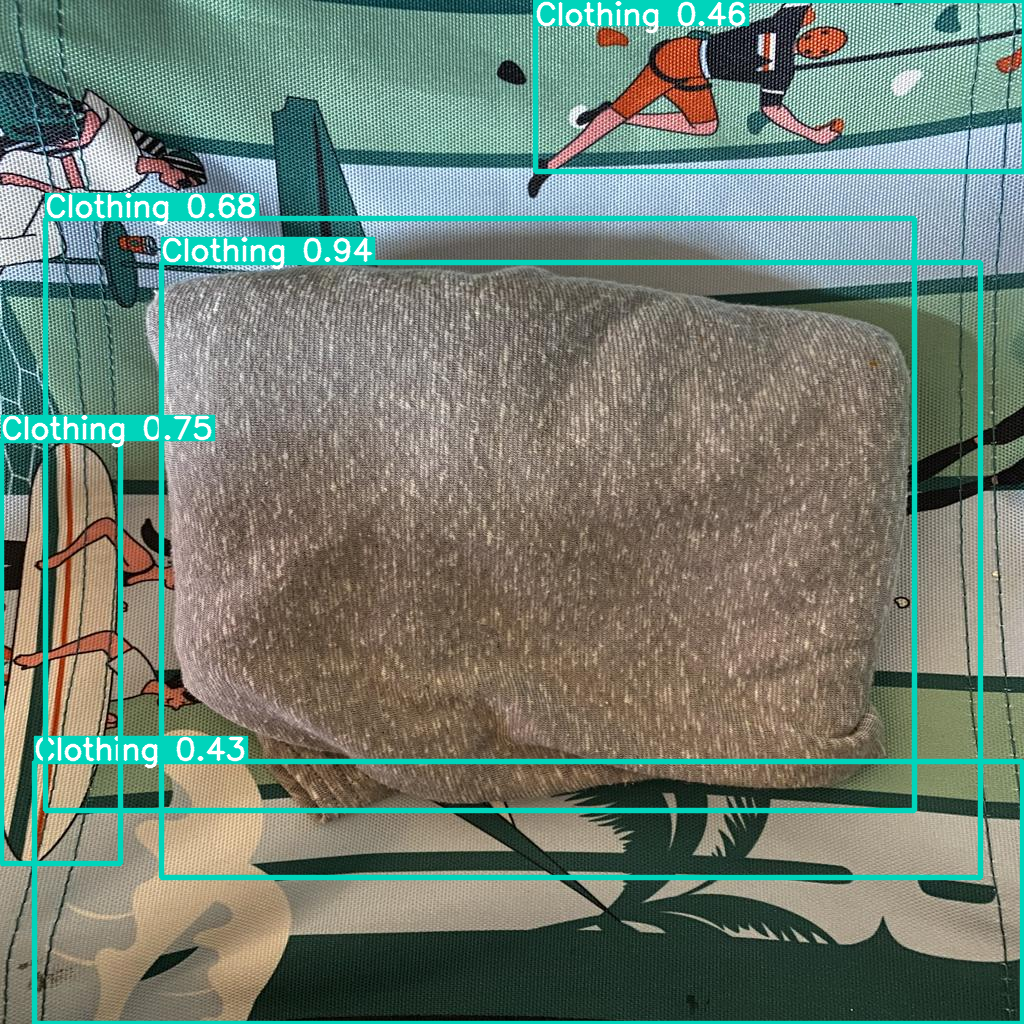

In [8]:
# detection 된 이미지 확인하기
from ultralytics import YOLO
import csv
from pathlib import Path
import os
from PIL import Image

model = YOLO('/data/ephemeral/home/level2-objectdetection-cv-10/develop/Ko/yolo_train/yolov8n14/weights/best.pt')

# image_path = '/data/ephemeral/home/level2-objectdetection-cv-10/dataset/test'
# results = model(image_path)

results = model('/data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0003.jpg')
print(results)
for r in results:
    
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results.jpg')  # save imag

In [9]:
from ultralytics import YOLO
import csv
import os
from pathlib import Path

model = YOLO('/data/ephemeral/home/level2-objectdetection-cv-10/develop/Ko/yolo_train/yolov8n8/weights/best.pt')

# 이미지 디렉토리
image_dir = Path('/data/ephemeral/home/level2-objectdetection-cv-10/dataset/test')

with open('detections.csv', 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['PredictionString', 'image_id'])

    # 디렉토리 내의 이미지 파일을 정렬하여 순서대로 처리
    for image_path in sorted(image_dir.glob('*.jpg')):
        # 이미지에서 객체 탐지
        results = model(str(image_path))

        # 결과 처리 및 CSV 파일에 저장
        for r in results:
            result_str = ''
            for box, conf, cls_id in zip(r.boxes.xyxy, r.boxes.conf, r.boxes.cls):
                x1, y1, x2, y2 = box
                result_str += f"{int(cls_id)} {conf} {x1} {y1} {x2} {y2} "

            # 이미지 경로 재구성
            image_id = 'test/' + image_path.name
            # CSV 파일에 결과 작성
            csv_writer.writerow([result_str, image_id])

# !python detect_yolo.py --device 0 --img-size 1024 --conf-thres 0.001 --iou-thres 0.45 --nosave --weights /data/ephemeral/home/level2-objectdetection-cv-10/develop/Ko/yolo_train/yolov8n8/weights/best.pt --source /data/ephemeral/home/level2-objectdetection-cv-10/dataset/yolo_test/images --name yolov8_x1_test_data


# # CSV 파일 초기화 및 헤더 작성
# csv_file = open('detections.csv', 'w', newline='')
# csv_writer = csv.writer(csv_file)
# csv_writer.writerow(['PredictionString', 'image_id'])

# # 결과 처리 및 CSV 파일에 저장
# for r in results:
#     result_str = ''
#     for box, conf, cls_id in zip(r.boxes.xyxy, r.boxes.conf, r.boxes.cls):
#         x1, y1, x2, y2 = box
#         result_str += f"{int(cls_id)} {conf} {x1} {y1} {x2} {y2} "

#     # 이미지 경로 재구성
#     image_id = os.path.basename(image_path)  # 이미지 파일 이름 추출
#     # image_id = 'test/' + os.path.splitext(image_id)[0]  # 확장자 제거
#     image_id = os.path.splitext(image_id)[0]  # 확장자 제거
#     # CSV 파일에 결과 작성
#     csv_writer.writerow([result_str, image_id])

# # 파일 닫기
# csv_file.close()

#여기까지 코드 괜춘---

# with open('detections.csv', 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)

#     # 모든 탐지 결과를 순회하며 정보 추출 및 저장
#     for r in results:
#         # 각 탐지된 객체에 대한 정보를 문자열로 변환
#         result_str = ''
#         for box, conf, cls_id in zip(r.boxes.xyxy, r.boxes.conf, r.boxes.cls):
#             x1, y1, x2, y2 = box
#             result_str += f"{int(cls_id)} {conf} {x1} {y1} {x2} {y2} "

#         # 결과 문자열과 이미지 경로를 CSV 파일에 작성
#         csv_writer.writerow([result_str, 'test/0000.jpg'])
        
        
        
# import torch
# for r in results:
#     # for *xyxy, conf, cls in r.boxes:
#     print(r.boxes.xyxy)
#     print(r.boxes.conf)
#     print(r.boxes.cls)

# CSV 파일 초기화
# with open('detections.csv', 'w', newline='') as csv_file:
#     csv_writer = csv.writer(csv_file)

#     # 모든 탐지 결과를 순회하며 정보 추출 및 저장
#     for r in results:
#         boxes = r.boxes.xyxy  # 바운딩 박스 좌표
#         confidences = r.boxes.conf  # 신뢰도 점수
#         class_ids = r.boxes.cls  # 클래스 ID

#         # 각 탐지된 객체에 대한 정보를 CSV 파일에 작성
#         for box, conf, cls_id in zip(boxes, confidences, class_ids):
#             x1, y1, x2, y2 = box
#             csv_writer.writerow([cls_id, conf, x1, y1, x2, y2])





image 1/1 /data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0000.jpg: 640x640 2 Papers, 4 Plastics, 8 Plastic bags, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0001.jpg: 640x640 1 Paper pack, 1 Metal, 11.4ms
Speed: 3.3ms preprocess, 11.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0002.jpg: 640x640 1 General trash, 6 Papers, 1 Glass, 11.1ms
Speed: 3.0ms preprocess, 11.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0003.jpg: 640x640 5 Clothings, 11.2ms
Speed: 3.1ms preprocess, 11.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /data/ephemeral/home/level2-objectdetection-cv-10/dataset/test/0004.jpg: 640x640 2 General tras